In [1]:
# =============================================================================
# Created By:     Kai Metzger
# Created School: Franz-Oberthuer-Schule Wuerzburg
# Created Email:  metzgerkai@franz-oberthuer-schule.de
# Created Date:   Sat April 05 09:54 UTC 2025
# Version:        1.0.1
# =============================================================================
"""The Module has been build for training the symbols dataset with images + 
ground truth on a Raspberry Pi 5 with a standard USB camera. An image with a 
resolution of 640px x 480px can be recorded with the Python script 
create-symbols-dataset.py.
The files in the dataset <symbols> should be ordered in the following
manner:             > explanation
- symbols      
  - dataset1        > dataset version (dataset1 - 3 where used in the project)
    - data          > images (.png files)
    - gt            > ground truth (.txt files with class labels 1-4)
"""

# =============================================================================
# Import
# =============================================================================
import cv2
import os
import numpy as np
from keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import keras
import tensorflow as tf

# Enable Nvidia GPUs by un-commenting this line 
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
XLA_FLAGS="--xla_gpu_cuda_data_dir=/usr/"

# To get reproducable results with the same training setting random seed
SEED = 42
np.random.seed(SEED)
keras.utils.set_random_seed = SEED
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [2]:
# =============================================================================
# Declare variables
# =============================================================================
img_size_x = 32
img_size_y = 32
img_dim = img_size_x * img_size_y

# Change the following paths to your dataset path
home_dir = os.path.expanduser("~")
dataset_for_training = "dataset8"
img_dir = home_dir + "/ml_project/datasets/symbols/" + dataset_for_training + "/data"
gt_dir = home_dir + "/ml_project/datasets/symbols/" + dataset_for_training + "/gt"
checkpoint_filepath = home_dir + "/ml_project/datasets/symbols/" + dataset_for_training + "/chpt/"

print(img_dim)
print(img_dir)

1024
/home/pi/ml_project/datasets/symbols/dataset8/data


In [3]:
# =============================================================================
# Get number of data (image/label) 
# =============================================================================
anz_data = len(os.listdir(img_dir))
anz_data = int(anz_data)
dataset = np.zeros((anz_data, img_size_x, img_size_y), dtype=float)
ground_truth = np.zeros((anz_data), dtype=int)
print("dataset size:", anz_data)

dataset size: 700


In [4]:
# =============================================================================
# Define functions
# =============================================================================
# Change image size and convert to grayscale images
def pic_prep (image, x, y):
  image = cv2.resize(image, (y,x))                # change image size
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to grayscale
  image = image / 255                             # image normalization
  return image

# Shuffle images
def unison_shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


In [5]:
# =============================================================================
# Callback for training
# =============================================================================
# Set verbose flag to 0 to omit loss/accuracy output per epoch
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath + "chpt.keras",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True,
    verbose = 1)

In [6]:
# =============================================================================
# Read dataset
# =============================================================================
for i in range(0, anz_data, 1):
    img_name = img_dir + '/' + str(i) + '.png'      # create file names
    image = cv2.imread(img_name)                    # read image
    image = pic_prep(image, img_size_x, img_size_y) # prepare image
    dataset[i,:,:] = image                          # 2d-image to 3d-array
    
    txt_name = gt_dir + '/' + str(i) + '.txt'       # create gt file names
    ground_truth[i] = np.genfromtxt(txt_name, delimiter=',') 

In [7]:
# =============================================================================
# Prepare dataset: train set (80%) and test set (20%)
# =============================================================================
#dataset = dataset.reshape(anz_data, img_dim) # convert into 2d array (all pixel in one row)
#ground_truth = ground_truth.reshape(anz_data, 1)

dataset, ground_truth = unison_shuffle(dataset, ground_truth)

trainset = np.random.choice(dataset.shape[0],
                            int(dataset.shape[0]*0.80), 
                            replace=False)
train_data = dataset[trainset,:]
train_gt = ground_truth[trainset]
train_gt = utils.to_categorical(train_gt)

testset = np.delete(np.arange(0, len(ground_truth) ), 
                    trainset) 
test_data = dataset[testset,:]
test_gt = ground_truth[testset]
test_gt = utils.to_categorical(test_gt)

print(ground_truth.shape)
print(dataset.shape)
print(trainset.shape)
print(train_data.shape)
print(train_gt.shape)

(700,)
(700, 32, 32)
(560,)
(560, 32, 32)
(560, 4)


In [8]:
# =============================================================================
# Create neural network with FC layers and some neurons per layer.
# =============================================================================
""" model = models.Sequential()
model.add(layers.Dense(64,input_dim=img_dim,activation='relu'))
model.add(layers.Dense(32,input_dim=img_dim,activation='relu'))
model.add(layers.Dense(32,input_dim=img_dim,activation='relu'))
model.add(layers.Dense(128,input_dim=img_dim,activation='relu'))
model.add(layers.Dense(4,activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', 
              optimizer=opt, 
              metrics=['accuracy']) """


" model = models.Sequential()\nmodel.add(layers.Dense(64,input_dim=img_dim,activation='relu'))\nmodel.add(layers.Dense(32,input_dim=img_dim,activation='relu'))\nmodel.add(layers.Dense(32,input_dim=img_dim,activation='relu'))\nmodel.add(layers.Dense(128,input_dim=img_dim,activation='relu'))\nmodel.add(layers.Dense(4,activation='sigmoid'))\nopt = keras.optimizers.Adam(learning_rate=0.0001)\nmodel.compile(loss='mean_squared_error', \n              optimizer=opt, \n              metrics=['accuracy']) "

In [9]:
# =============================================================================
# Create neural network with 4 layers and (64, 32, 16, 4) neurons per layer.
# =============================================================================
input_shape = (32, 32, 1)

model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.10))

model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(4,activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='mean_squared_error', 
              optimizer=opt, 
              metrics=['accuracy'])

model.summary()


/home/pi/ml_project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 665,700 (2.54 MB)

 Trainable params: 665,700 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# =============================================================================
# Train the neuronal network e.g. for 300 epochs.
# =============================================================================
history = model.fit(train_data, 
                    train_gt, 
                    batch_size=32, 
                    epochs=50, 
                    verbose=0, 
                    shuffle=True, 
                    validation_data=(test_data, test_gt), 
                    callbacks=[model_checkpoint_callback])

2025-11-22 14:20:13.449403: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-11-22 14:20:21.141668: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.20714, saving model to /home/pi/ml_project/datasets/symbols/dataset8/chpt/chpt.keras

Epoch 2: val_accuracy improved from 0.20714 to 0.22143, saving model to /home/pi/ml_project/datasets/symbols/dataset8/chpt/chpt.keras

Epoch 3: val_accuracy did not improve from 0.22143

Epoch 4: val_accuracy improved from 0.22143 to 0.42857, saving model to /home/pi/ml_project/datasets/symbols/dataset8/chpt/chpt.keras

Epoch 5: val_accuracy improved from 0.42857 to 0.57857, saving model to /home/pi/ml_project/datasets/symbols/dataset8/chpt/chpt.keras

Epoch 6: val_accuracy improved from 0.57857 to 0.67857, saving model to /home/pi/ml_project/datasets/symbols/dataset8/chpt/chpt.keras

Epoch 7: val_accuracy improved from 0.67857 to 0.71429, saving model to /home/pi/ml_project/datasets/symbols/dataset8/chpt/chpt.keras

Epoch 8: val_accuracy did not improve from 0.71429

Epoch 9: val_accuracy did not improve from 0.71429

Epoch 10: val_accuracy improved from

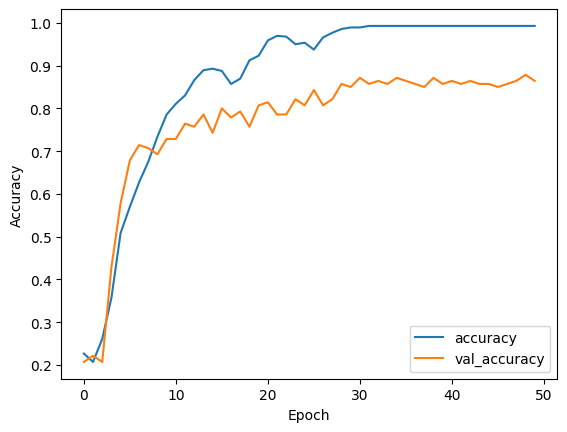

In [11]:
# =============================================================================
# Plot train and val accuracy.
# =============================================================================

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


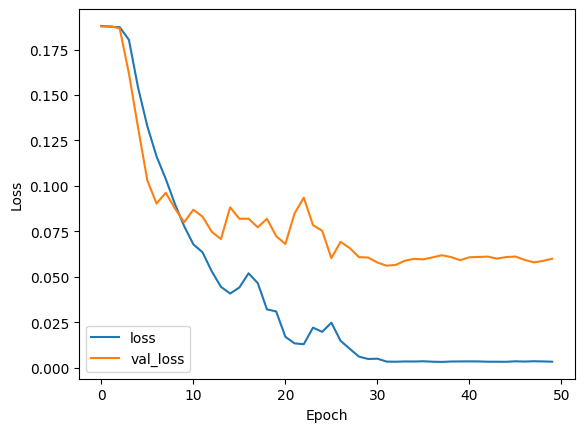

In [12]:
# =============================================================================
# Plot train and val loss.
# =============================================================================

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.show()

In [13]:
# =============================================================================
# Load pretrained dataset weights to e.g. test on new (unseen) data.
# =============================================================================
model.load_weights(checkpoint_filepath + "chpt.keras")

In [14]:
# =============================================================================
# Test dataset on xxx.
# =============================================================================
score = model.evaluate(test_data, test_gt, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8516 - loss: 0.0641

2025-11-22 14:24:25.449703: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8666 - loss: 0.0619
Test score: 0.05878140404820442
Test accuracy: 0.8785714507102966


In [15]:
# =============================================================================
# Testing on a single image.
# =============================================================================
data_pred = np.zeros((1, img_size_x, img_size_y), dtype=float)
img_pred = cv2.imread(home_dir + "/ml_project/datasets/symbols/" + dataset_for_training + "/data/14.png")
img_pred = pic_prep(img_pred, img_size_x, img_size_y)
data_pred[0,:,:] = img_pred
data_pred = data_pred.reshape(1,img_dim)
result = model.predict(data_pred)
result = np.round(result, decimals=2)

print("Probability for classes: (cross, circle, triangle, square) in percent", 
      result)

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(1, 1024), dtype=float32). Expected shape (None, 32, 32, 1), but input has incompatible shape (1, 1024)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 1024), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [ ]:
# =============================================================================
# Output class: 
# translate class label (0,1,2,3) to class (cross, circle, triangle, square).
# =============================================================================

max_res = 0
res_index = 4
for i in range(0, 4, 1):
    if result[0,i] > max_res:
        max_res = result[0,i]
        res_index = i

if res_index == 0:
    print('Cross detected!')
elif res_index == 1:
    print('Circle detected!')
elif res_index == 2:
    print('Triangle detected!')
elif res_index == 3:
    print('Square detected!')
elif res_index == 4:
    print('Error!')